In [1]:
import numpy as np
import skvideo.io
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.measure import label
from skimage.morphology import remove_small_objects, erosion, dilation, disk

from trackbox import *

### 0. Load the video
* Change `filename = "name_of_video.wmv"` to the name of your own video.
* Change `subsample=1` to `n` to speed-up the video by `n` times.
* Change `start` and `end` to the MM:SS format (e.g., `3:11`) to trim the video.

Frame rate of the video:  15
(3600, 360, 640, 3) (3600, 360, 640)


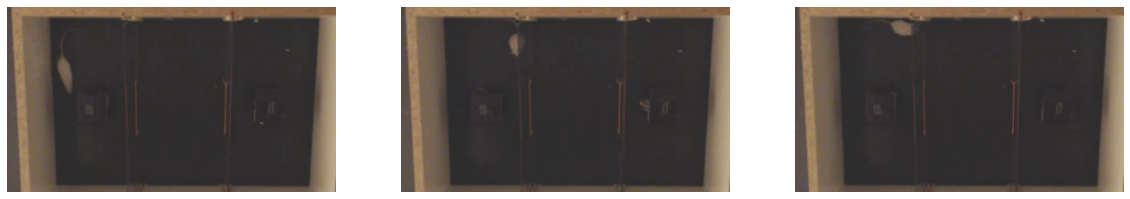

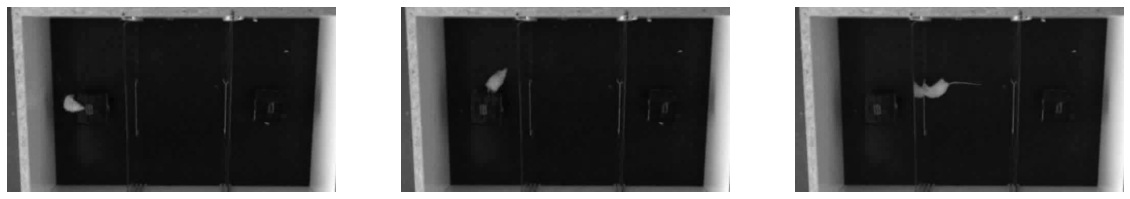

In [2]:
filename = "name_of_video.wmv"
height, width = 28, 65 # height and width of the chamber in cm
kwargs = {
    "subsample": 2,   # subsampling ratio of the video
    "start": "0:09",  # start time of the trimmed video 
    "end": "4:09",    # end time of the trimmed video 
}
video, video_gray, frame_rate = load_video(filename, **kwargs)
show_rand_imgs(video, 3)
show_rand_imgs(video_gray, 3, 'gray')

### 1. Find valid region in the field-of-view (FoV)

/Users/zudilin/Documents/GitHub/tracking_toolbox/trackbox/tracking.py:14: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  segmentation = remove_small_objects(segmentation, size_thres)


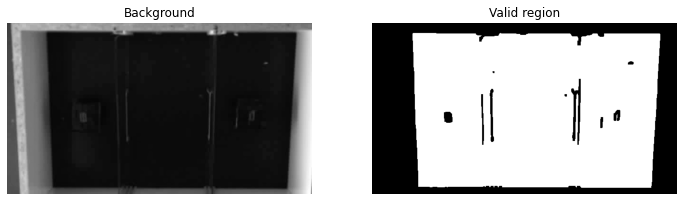

In [3]:
background = np.median(video_gray, axis=0)
valid_region, pix_height, pix_width = find_valid_region(background)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(background, cmap='gray')
plt.axis('off')
plt.title('Background')
plt.subplot(122)
plt.imshow(valid_region, cmap='gray')
plt.axis('off')
plt.title('Valid region')
plt.show()
perpix_dist = ((height / pix_height) + 
               (width / pix_width)) / 2.0

### 2. Process and save the video

In [4]:
all_centers = []
center_video = np.zeros(video_gray.shape, dtype=np.uint8)
for i in list(range(video_gray.shape[0])):
    center = segment_image(video_gray[i]-background, show_imgs=False, valid_region=valid_region)
    if len(center)==2:
        center_video[i, center[0], center[1]] = 1
        all_centers.append(center)
save_video(video, video_gray, center_video, track=True)

/Users/zudilin/Documents/GitHub/tracking_toolbox/trackbox/tracking.py:47: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  segmentation = remove_small_objects(segmentation, size_thres)


(3600, 360, 640, 3)


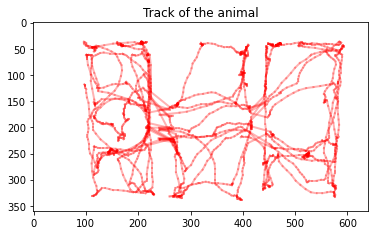

Travel length is 13240.39 pixels, which is 1403.01 cm.


In [5]:
%matplotlib inline
travel_length = 0
temp = np.ones(video_gray[0].shape, dtype=np.uint8)*255
temp[0,0] = 0
ditance_map = np.zeros(temp.shape, dtype=np.float64)
plt.imshow(temp, cmap='gray')
for j in range(len(all_centers)-1):
    dist = center2dist(all_centers[j], all_centers[j+1])
    if dist < 100:
        travel_length += dist
        ditance_map[all_centers[j][0], all_centers[j][1]] += dist
        plt.plot([all_centers[j][1], 
                  all_centers[j+1][1]], 
                 [all_centers[j][0],
                  all_centers[j+1][0]], 'r', alpha=0.3, linewidth=2)
plt.axis('on')
plt.title('Track of the animal')
plt.show()
print("Travel length is %.2f pixels, which is %.2f cm." % (travel_length, travel_length*perpix_dist))

### 3. Interactive measurement

<IPython.core.display.Javascript object>


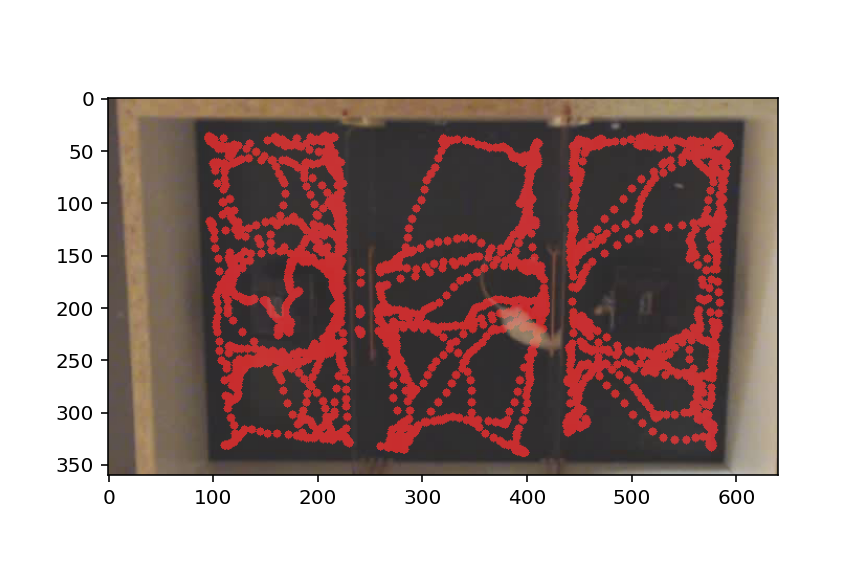


 click  -->  release


In [9]:
heatmap = center_video.max(0)
heatmap = dilation(heatmap, disk(4))
heatmap = np.stack([heatmap, 
                    np.zeros_like(heatmap),
                    np.zeros_like(heatmap)], 2)
heatmap = (heatmap*255).astype(np.uint8)
heatmap = np.clip(heatmap, a_min=0, a_max=200)
heatmap = np.maximum(heatmap, video[0])

# Interactive measurement
%matplotlib notebook
interactive_measure(heatmap, center_video, ditance_map, 
                    perpix_dist, frate=frame_rate)

In [7]:
## This cell is intentionally left blank.